In [1]:
import os
import yaml
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import random

# Import required components from your project
from data_loader import load_and_segment_data, SensorDataset, train_val_test_split
from models.cnn_model import CNNModel
from models.lstm import LSTMModel
from models.rnn import VanillaRNNModel
from models.ntflstm import LSTMAutoregressive

# -------------------------------
# CONFIGURATION & DATA LOADING
# -------------------------------
# Load configuration from YAML file
config_path = os.path.join("config", "verylong.yaml")
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
column_names = ["Gyroscope X", "Gyroscope Y","Gyroscope Z", "Acceleration X","Acceleration Y","Acceleration Z"]

# Load data (using training set for visualization; adjust data_dir as needed)
X, y, labels = load_and_segment_data(
    data_dir="dataset/train",
    window_size=config['window_size'],
    predict_size=config['predict_size'],
    balance_config=config
)

# Split data into train, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X, y, labels, test_size=0.2, val_size=0.4, random_state=42
)
# X_train, X_val, X_test, y_train, y_val, y_test, labels_train, labels_val, labels_test = train_val_test_split(
#     X, y, labels, test_size=0.2, val_size=0.4, random_state=42
# )

# Create the training dataset (normalization is applied in SensorDataset)
train_dataset = SensorDataset(X_train, y_train, normalize=True)
#train_dataset = SensorDataset(X_train, y_train, labels=X_train_labels, normalize=True)

# -------------------------------
# MODEL LOADING
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if config["model_type"] == "cnn":
    model = CNNModel(window_size=config['window_size'],
                 predict_size=config['predict_size'],
                 num_features=6)
elif config["model_type"] == "lstm":
        model = LSTMModel(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
elif config["model_type"] == "ntflstm":
        model = LSTMAutoregressive(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
elif config["model_type"] == "rnn":
        model = VanillaRNNModel(input_size=6,hidden_size=config.get('hidden_size', 64), num_layers=config.get('num_layers', 2),predict_size=config['predict_size'])
model_path = config.get('model_save_path', "./output_model/verylong_2.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()



ValueError: too many values to unpack (expected 6)

In [77]:
# -------------------------------
# DEFINE VISUALIZATION FUNCTION
# -------------------------------
def visualize_sample(sample, model, config, device):
    """
    Given a sample (tuple of (input, ground truth)) from the dataset,
    this function predicts the output using the model and plots:
      - Input sequence for each sensor channel.
      - Ground truth sequence (solid line) for each sensor channel.
      - Predicted sequence (dotted line) for each sensor channel.
    The plots are created in two figures (sensors 1-3 and sensors 4-6).
    """
    # Unpack sample: sample_X shape: (window_size, 6), sample_y shape: (predict_size, 6)
    sample_X, sample_y = sample
    sample_X = sample_X.unsqueeze(0)  # add batch dimension

    # Model prediction
    with torch.no_grad():
        pred_y = model(sample_X)  # shape: (1, predict_size, 6)
    
    # Remove batch dimension and convert to numpy arrays
    sample_X = sample_X.cpu().numpy().squeeze()    # (window_size, 6)
    sample_y = sample_y.cpu().numpy().squeeze()      # (predict_size, 6)
    pred_y   = pred_y.cpu().numpy().squeeze()        # (predict_size, 6)
    
    window_size = config['window_size']
    predict_size = config['predict_size']
    time_axis_input = np.arange(window_size)
    time_axis_pred  = np.arange(window_size, window_size + predict_size)
    
    # Plot sensors 1-3 in one figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    axes = [ax1, ax2, ax3]
    for idx, ax in enumerate(axes):
        ch = idx  # sensor channels 0,1,2
        ax.plot(time_axis_input, sample_X[:, ch], color=f'C{ch}', label="Input", linewidth=2)
        ax.plot(time_axis_pred, sample_y[:, ch], color=f'C{ch}', linestyle='-', marker='o', markersize=4, label="Ground Truth")
        ax.plot(time_axis_pred, pred_y[:, ch], color=f'C{ch}', linestyle=':', marker='x', markersize=4, label="Prediction")
        ax.set_title(column_names[ch])
        ax.set_xlabel("Time Step")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("Normalized Value")
        ax.legend()
    fig.suptitle("Sensors 1-3: Input, Ground Truth, and Prediction")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Plot sensors 4-6 in a second figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
    axes = [ax1, ax2, ax3]
    for idx, ax in enumerate(axes):
        ch = idx + 3  # sensor channels 3,4,5
        ax.plot(time_axis_input, sample_X[:, ch], color=f'C{ch}', label="Input", linewidth=2)
        ax.plot(time_axis_pred, sample_y[:, ch], color=f'C{ch}', linestyle='-', marker='o', markersize=4, label="Ground Truth")
        ax.plot(time_axis_pred, pred_y[:, ch], color=f'C{ch}', linestyle=':', marker='x', markersize=4, label="Prediction")
        ax.set_title(column_names[ch])
        ax.set_xlabel("Time Step")
        ax.grid(True)
        if idx == 0:
            ax.set_ylabel("Normalized Value")
        ax.legend()
    fig.suptitle("Sensors 4-6: Input, Ground Truth, and Prediction")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Visualizing sample index: 5


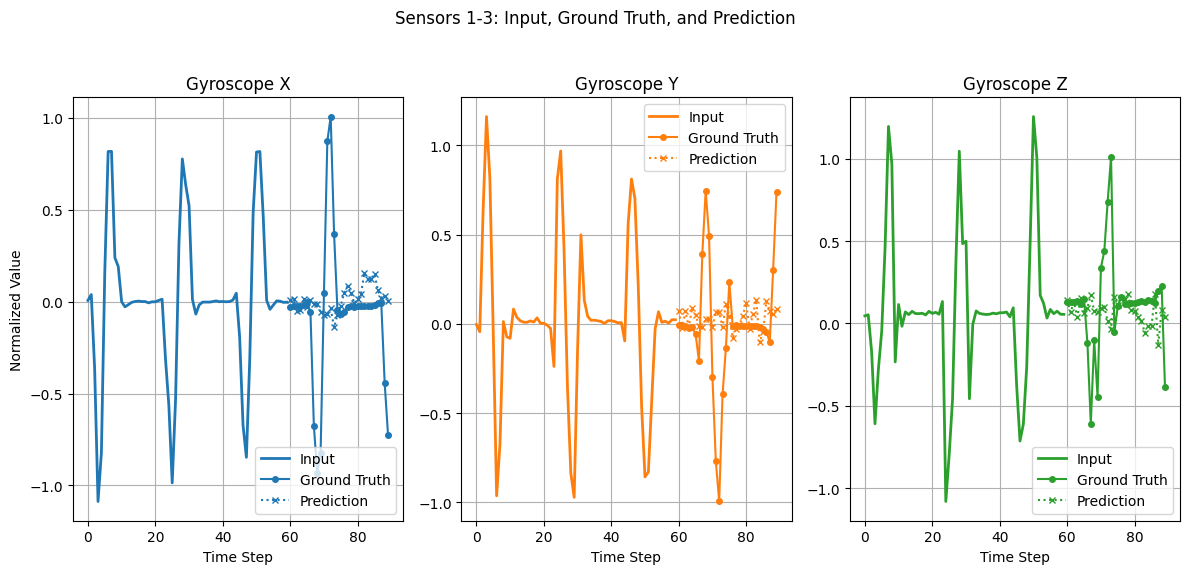

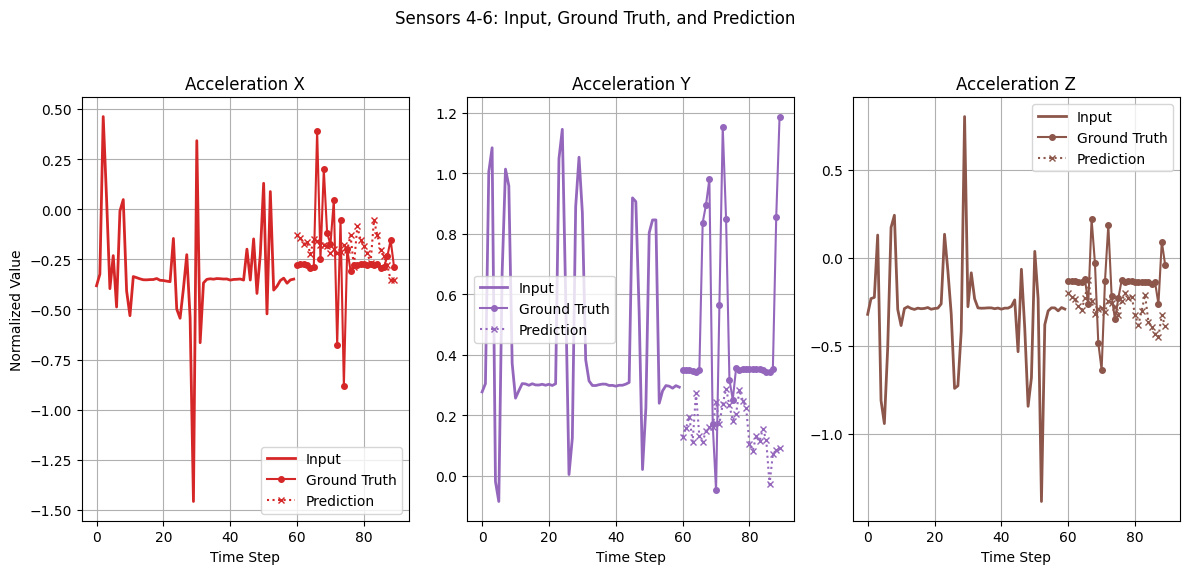

Visualizing sample index: 32


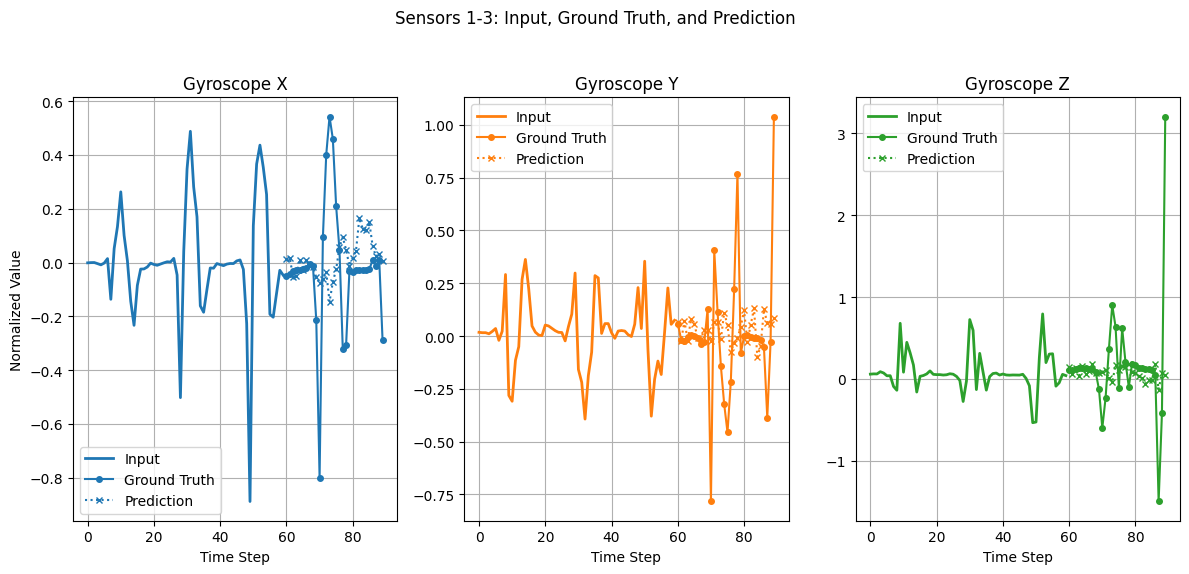

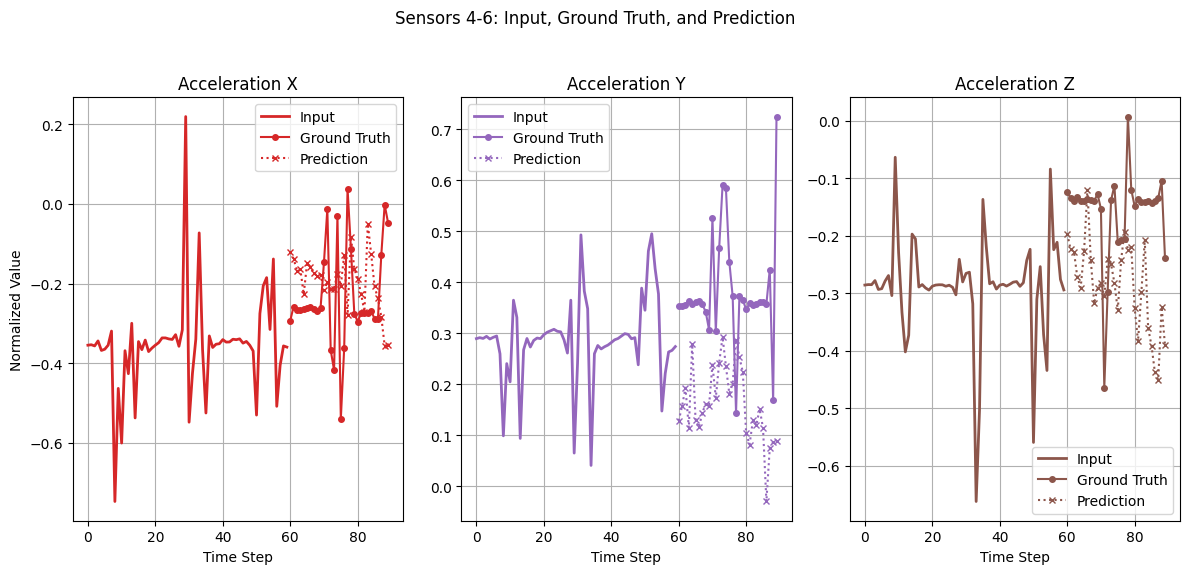

Visualizing sample index: 3


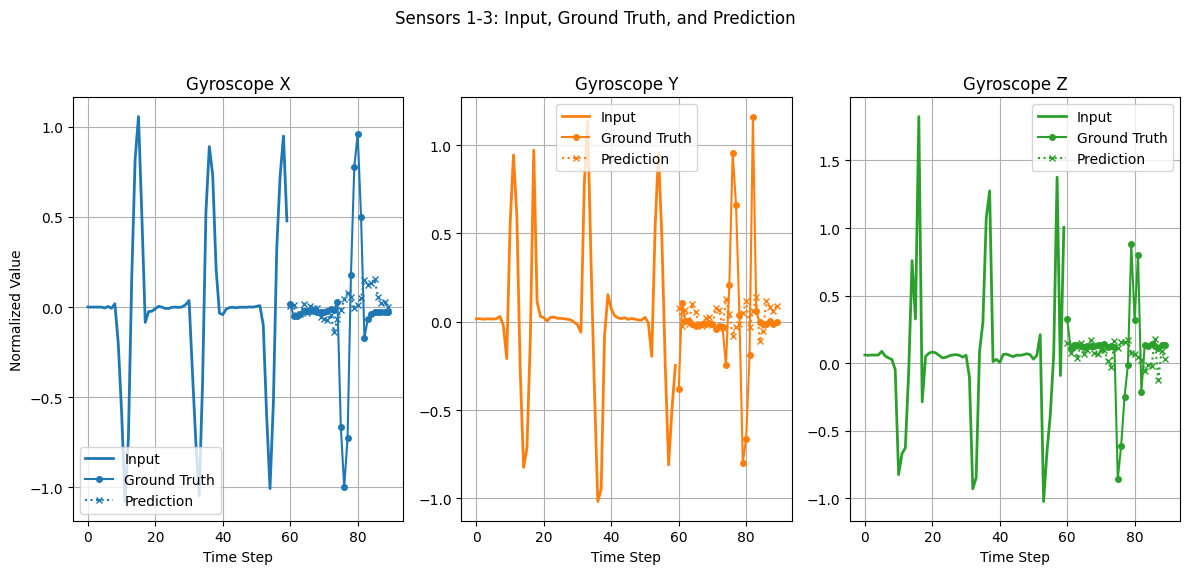

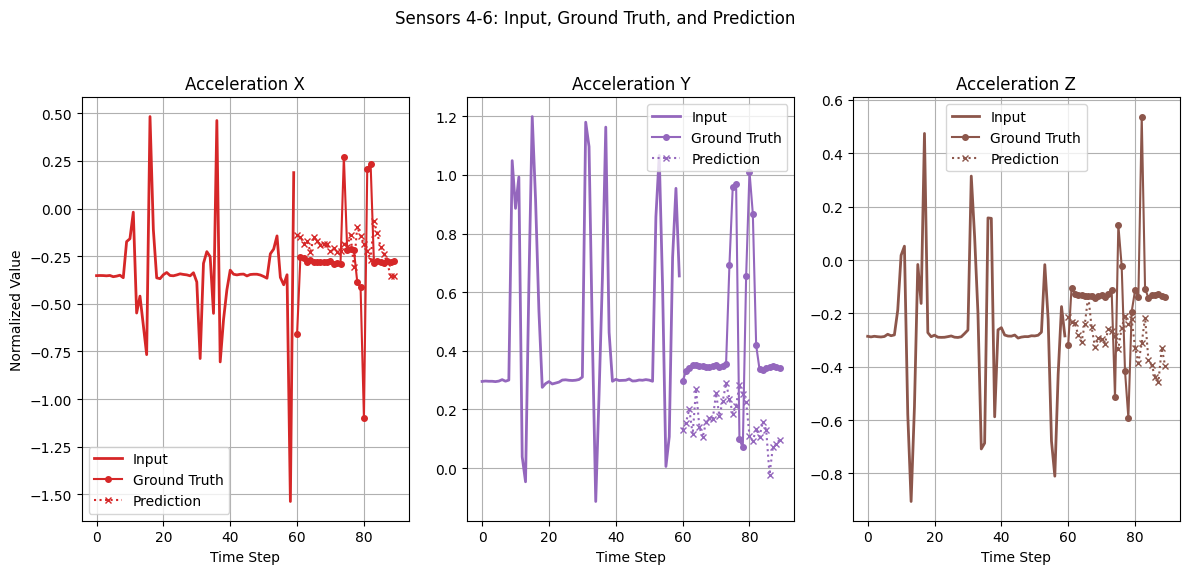

Visualizing sample index: 1


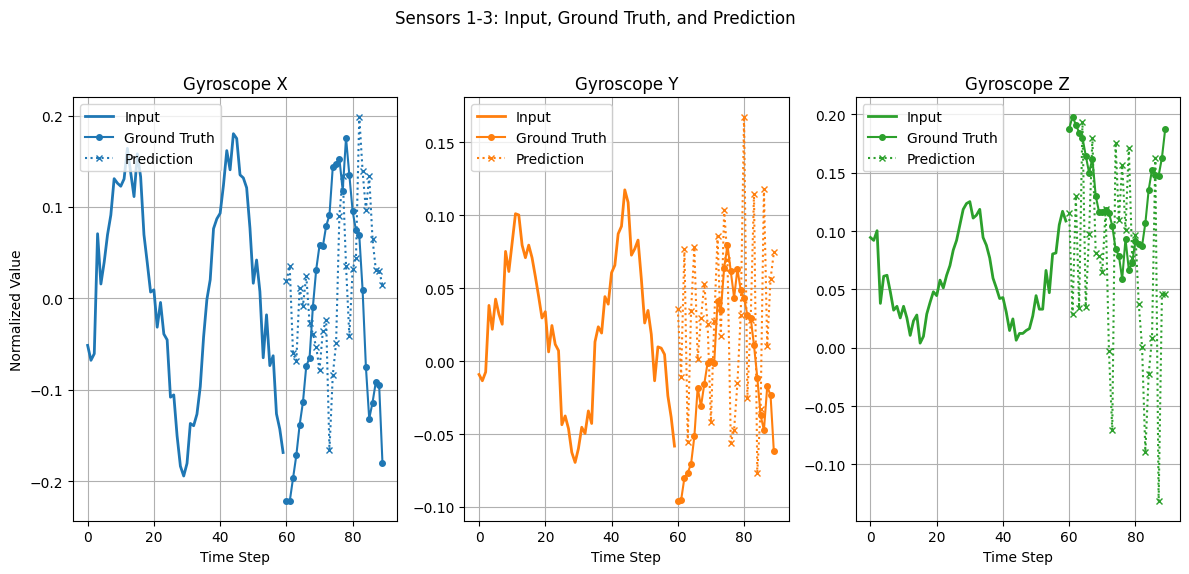

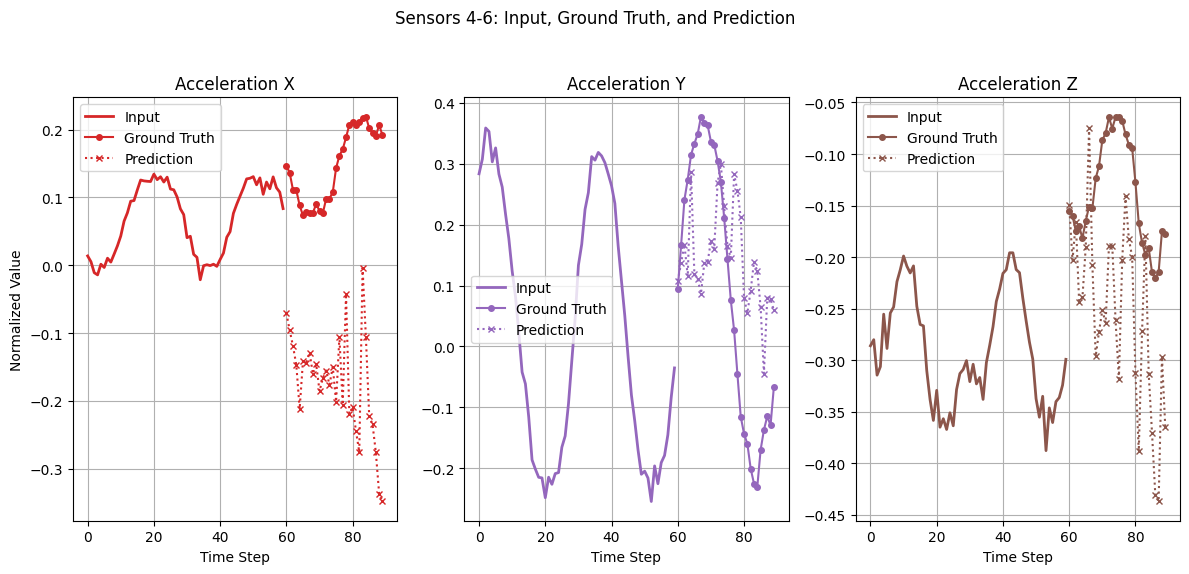

Visualizing sample index: 13


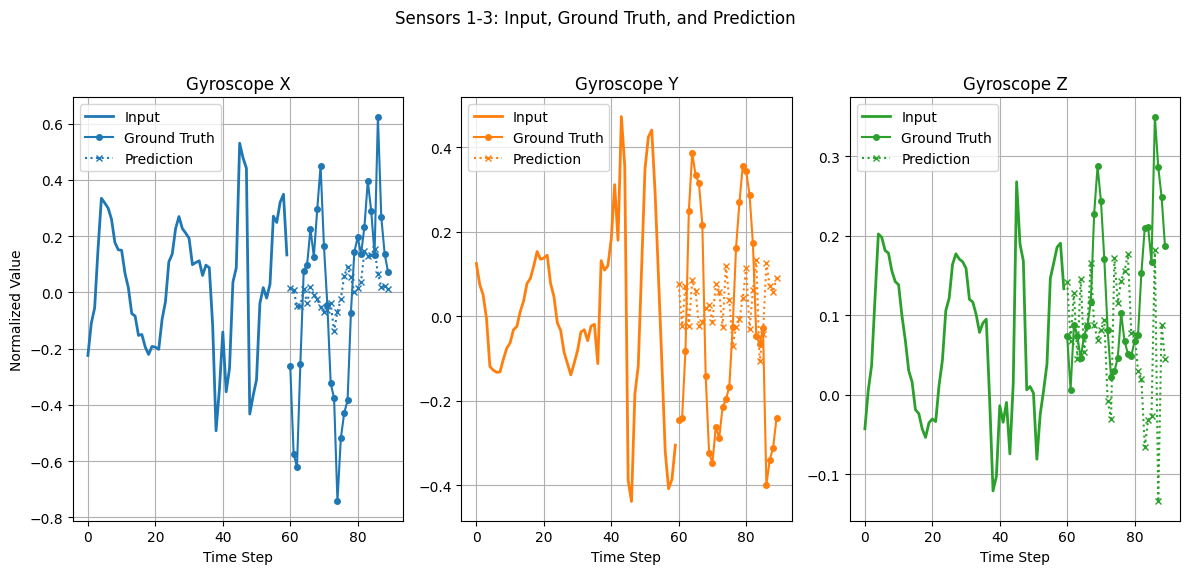

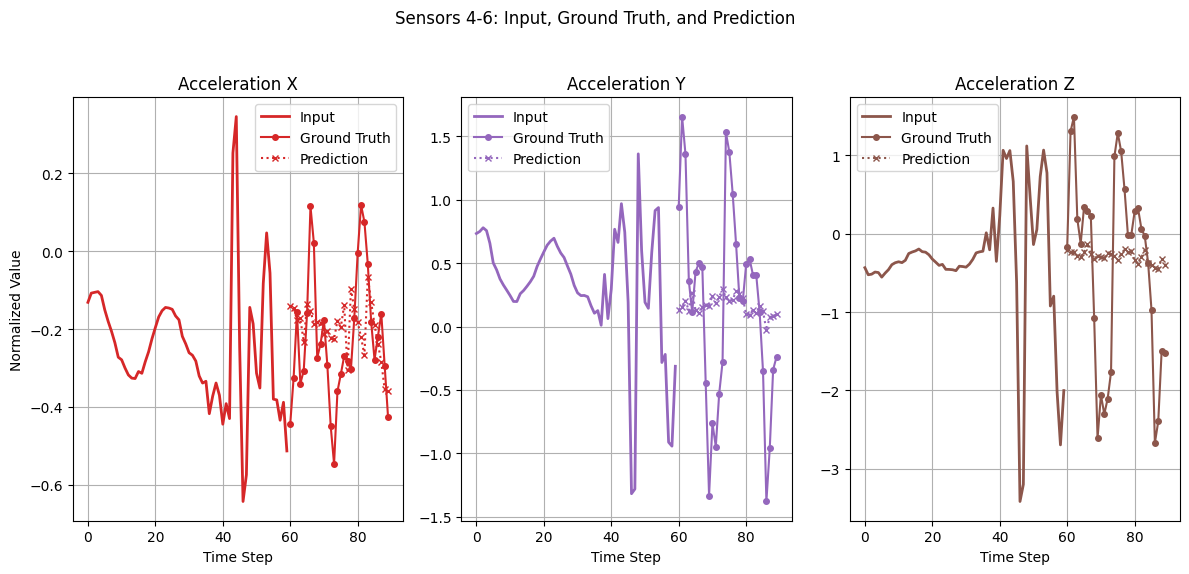

In [78]:
# -------------------------------
# RANDOMLY VISUALIZE MULTIPLE SAMPLES
# -------------------------------
# Define the number of random samples you wish to visualize
num_samples_to_visualize = 5

# Get random indices from the training dataset
total_samples = len(train_dataset)
random_indices = random.sample(range(total_samples), num_samples_to_visualize)

for idx in random_indices:
    print(f"Visualizing sample index: {idx}")
    sample = train_dataset[idx]
    visualize_sample(sample, model, config, device)


In [80]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def visualize_new_grouped_sensors(sample, model, config, device):
    """
    This function visualizes the predictions for sensor groups:
      - Gyroscope Sensor: channels 0,1,2
      - Acceleration Sensor: channels 3,4,5
    Each group is plotted in one figure using the same set of colors:
      (220,100,100), (245,151,66), (84,150,206) for x, y, z respectively.
    When shadow==True, a shaded region (color (188,150,120) with alpha=0.1) is added 
    from timestep 60 to the end of the plot.
    A combined legend is added that shows:
      - Sensor channels: "x", "y", "z" (with their corresponding colors)
      - Data styles: ground truth (black solid line with circular marker) and 
                     predicted data (black dotted line with "x" marker)
      - (Optionally) the prediction shadow patch if enabled.
    """
    # Unpack sample and add batch dimension
    sample_X, sample_y = sample
    sample_X = sample_X.unsqueeze(0)
    
    # Get model predictions
    with torch.no_grad():
        pred_y = model(sample_X)  # shape: (1, predict_size, 6)
    
    # Remove batch dimension and convert to numpy arrays
    sample_X = sample_X.cpu().numpy().squeeze()    # (window_size, 6)
    sample_y = sample_y.cpu().numpy().squeeze()      # (predict_size, 6)
    pred_y   = pred_y.cpu().numpy().squeeze()        # (predict_size, 6)
    
    window_size = config['window_size']
    predict_size = config['predict_size']
    time_axis_input = np.arange(window_size)
    time_axis_pred  = np.arange(window_size, window_size + predict_size)
    
    # Define the colors (normalize the RGB values by dividing by 255)
    colors = [(220/255, 100/255, 100/255), (245/255, 151/255, 66/255), (84/255, 150/255, 206/255)]
    g_channel_labels = [r'$g_x$', r'$g_y$', r'$g_z$']
    a_channel_labels = [r'$a_x$', r'$a_y$', r'$a_z$']

    
    legend_props = {'family': 'Arial'}
    
    # Light grid style parameters
    grid_kwargs = dict(color='white', linewidth=0)
    
    # Check if shadow is enabled (set to True in this example)
    shadow = True

    # --------------------- Gyroscope Sensor Plot (channels 0,1,2) ---------------------
    plt.figure(figsize=(10, 6))
    for idx in range(3):
        # Plot input
        plt.plot(time_axis_input, sample_X[:, idx], color=colors[idx], linewidth=2)
        # Plot ground truth
        plt.plot(time_axis_pred, sample_y[:, idx], color=colors[idx],
                 linestyle='-', marker='o', markersize=4)
        # Plot prediction
        plt.plot(time_axis_pred, pred_y[:, idx], color=colors[idx],
                 linestyle=':', marker='x', markersize=4)
        
        # Draw a connecting line from the last input to the first ground truth value
        plt.plot([time_axis_input[-1], time_axis_pred[0]],
                 [sample_X[-1, idx], sample_y[0, idx]],
                 color=colors[idx], linestyle='-', linewidth=2)
    
    # If shadow is enabled, add the shaded region
    if shadow:
        plt.axvspan(60, time_axis_pred[-1], facecolor=(188/255,150/255,120/255), alpha=0.1)
    
    # Create handles for sensor channels ("x", "y", "z")
    sensor_handles = [Line2D([0], [0], color=colors[i], lw=2, label=g_channel_labels[i])
                      for i in range(3)]
    # Create handles for data styles: ground truth and predicted data
    style_handles = [
        Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=4, label='ground truth'),
        Line2D([0], [0], color='black', linestyle=':', marker='x', markersize=4, label='predicted data')
    ]
    
    # Combine the handles together
    combined_handles = sensor_handles + style_handles
    
    # Optionally, add a handle for the shadow patch if enabled
    if shadow:
        shadow_handle = Patch(facecolor=(188/255,150/255,120/255), alpha=0.1, label='predict')
        combined_handles.append(shadow_handle)
    
    # Add the combined legend to the plot
    plt.legend(handles=combined_handles, loc='upper left', frameon=False, prop=legend_props)
    
    plt.xlabel("Time(s)")
    plt.ylabel("Gyroscope (a.u.)")
    plt.grid(True, **grid_kwargs)
    ax = plt.gca()
    for spine in ax.spines.values():    
        spine.set_linewidth(1.3)
    plt.tight_layout()
    plt.show()
    
    # --------------------- Acceleration Sensor Plot (channels 3,4,5) ---------------------
    plt.figure(figsize=(10, 6))
    for idx in range(3):
        ch = idx + 3  # channels for acceleration
        # Plot input
        plt.plot(time_axis_input, sample_X[:, ch], color=colors[idx], linewidth=2)
        # Plot ground truth
        plt.plot(time_axis_pred, sample_y[:, ch], color=colors[idx],
                 linestyle='-', marker='o', markersize=4)
        # Plot prediction
        plt.plot(time_axis_pred, pred_y[:, ch], color=colors[idx],
                 linestyle=':', marker='x', markersize=4)
        
        # Draw a connecting line from the last input to the first ground truth value
        plt.plot([time_axis_input[-1], time_axis_pred[0]],
                 [sample_X[-1, ch], sample_y[0, ch]],
                 color=colors[idx], linestyle='-', linewidth=2)
    
    if shadow:
        plt.axvspan(60, time_axis_pred[-1], facecolor=(188/255,150/255,120/255), alpha=0.1)
    
    # Create combined legend handles (same as before)
    sensor_handles = [Line2D([0], [0], color=colors[i], lw=2, label=a_channel_labels[i])
                      for i in range(3)]
    style_handles = [
        Line2D([0], [0], color='black', linestyle='-', marker='o', markersize=4, label='ground truth'),
        Line2D([0], [0], color='black', linestyle=':', marker='x', markersize=4, label='predicted data')
    ]
    combined_handles = sensor_handles + style_handles
    if shadow:
        shadow_handle = Patch(facecolor=(188/255,150/255,120/255), alpha=0.1, label='predict')
        combined_handles.append(shadow_handle)
    
    plt.legend(handles=combined_handles, loc='upper left', frameon=False, prop=legend_props)
    
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (g.a.u)")
    plt.grid(True, **grid_kwargs)
    plt.tight_layout()
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(1.3)
    plt.show()

Grouped visualization for sample index: 9


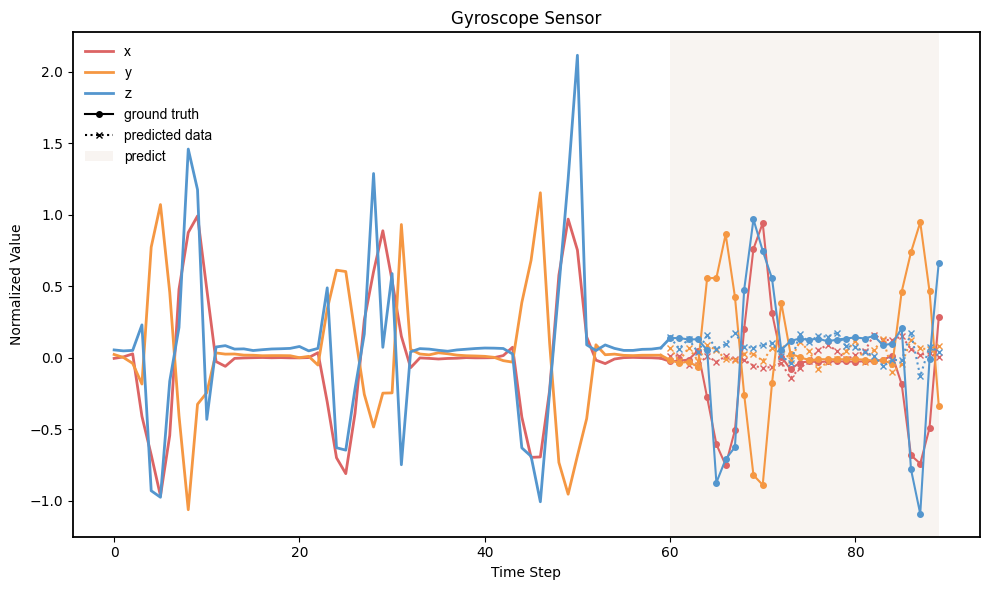

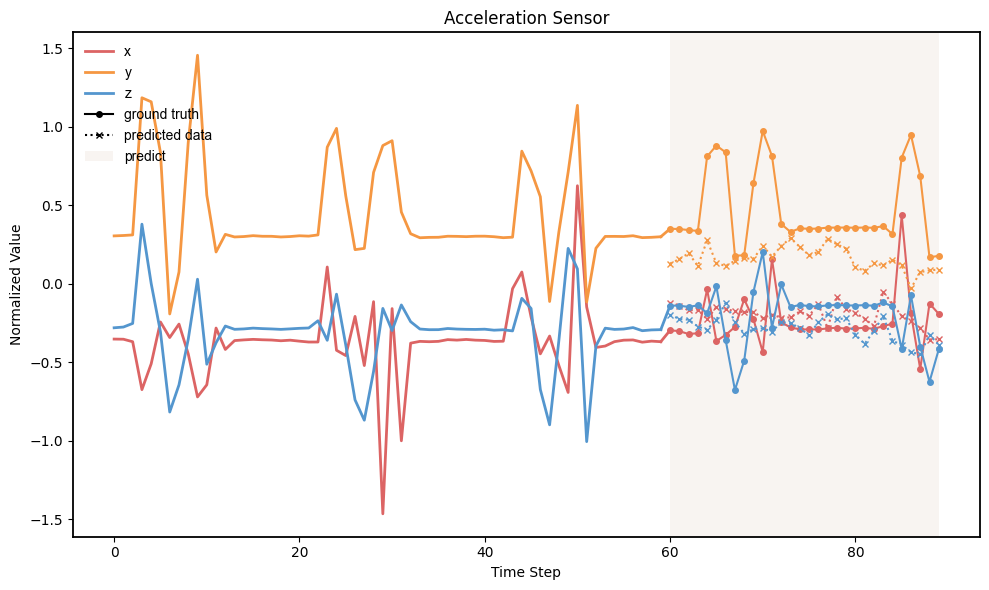

Grouped visualization for sample index: 28


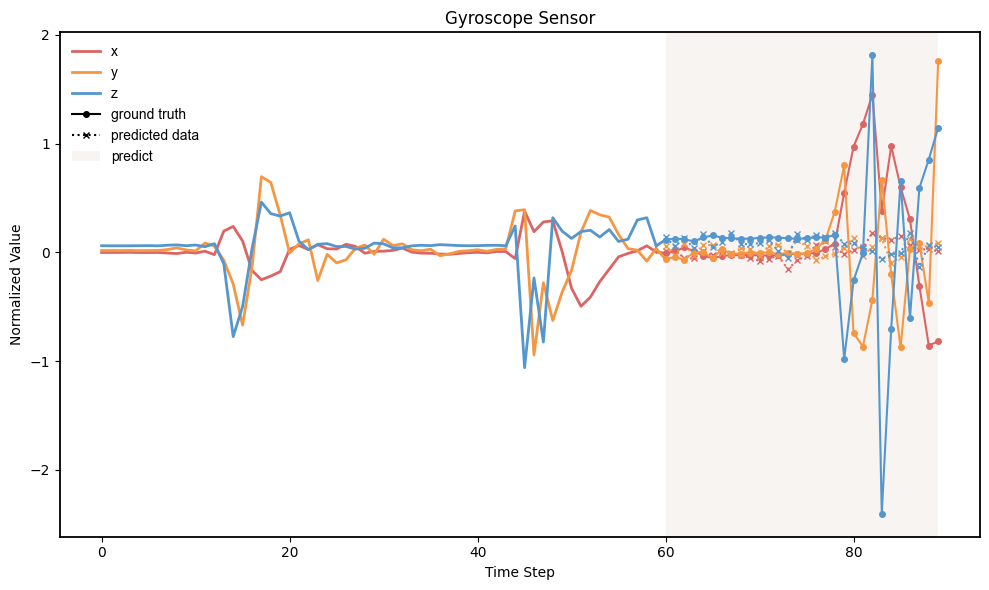

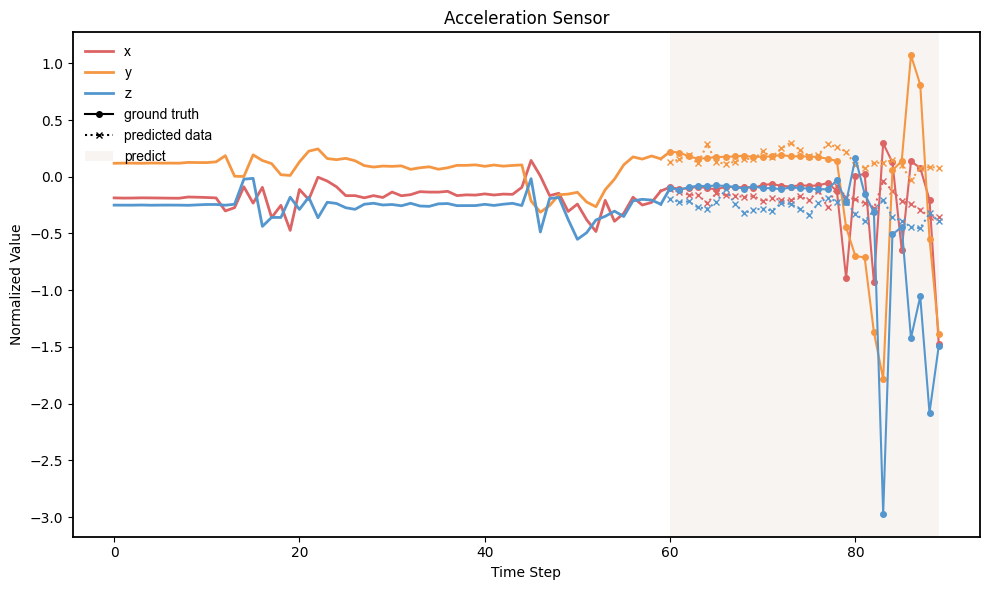

Grouped visualization for sample index: 37


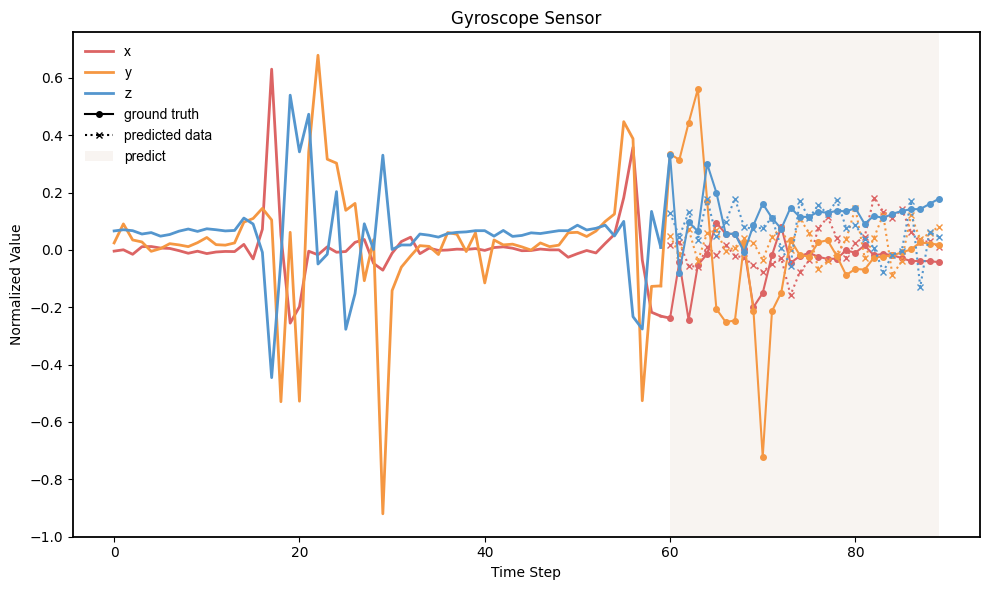

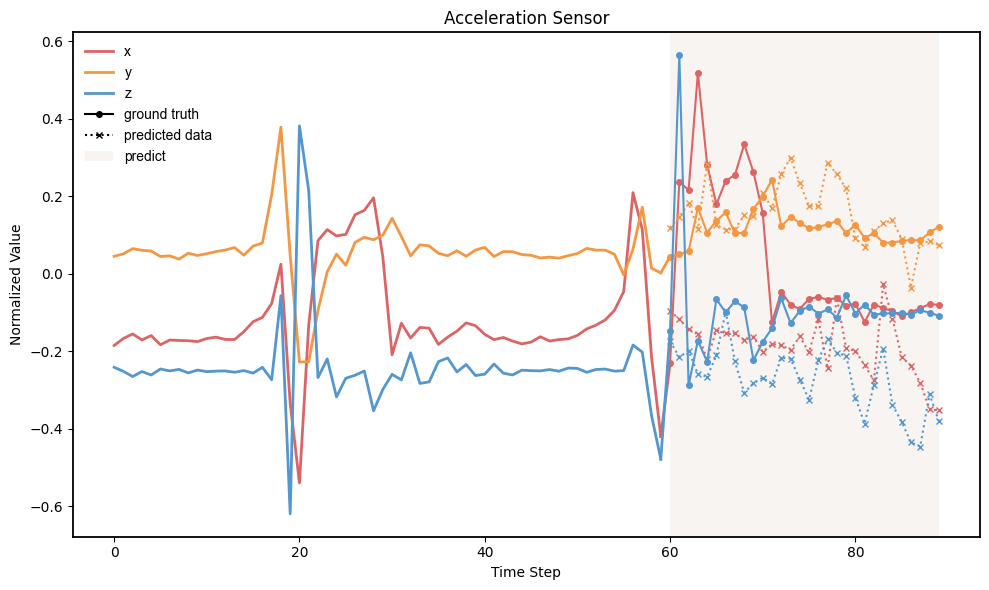

Grouped visualization for sample index: 13


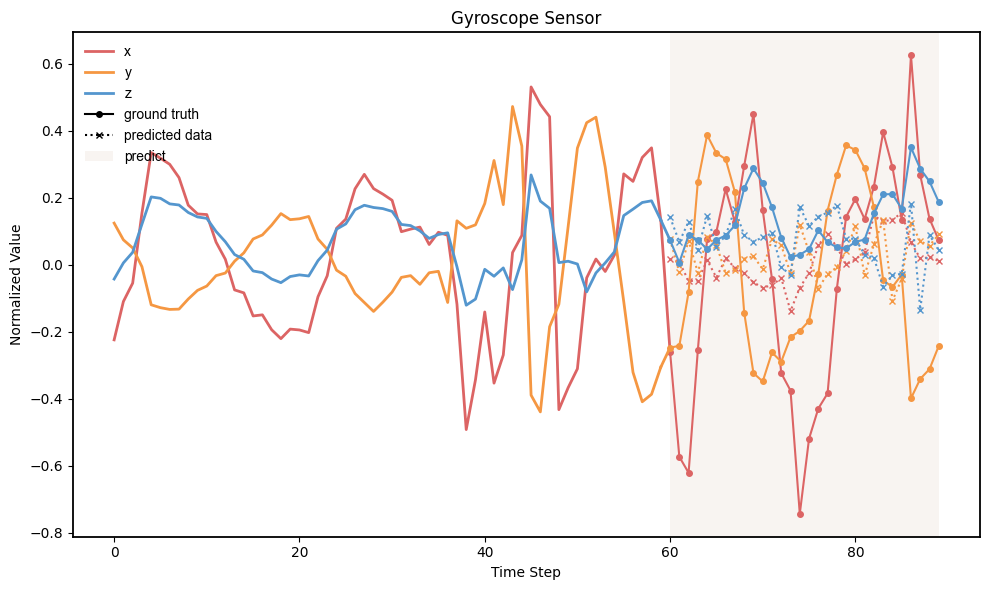

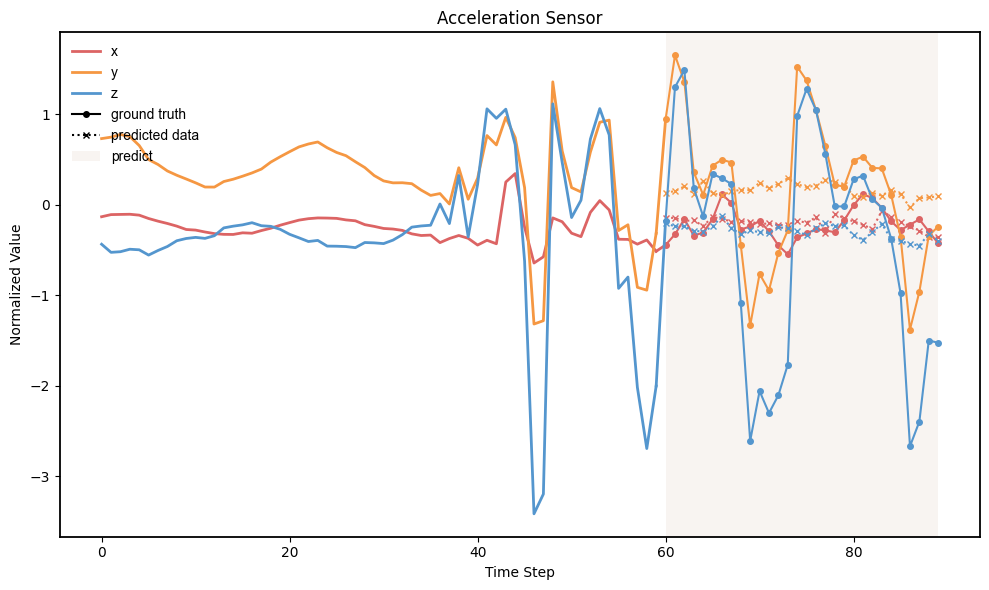

Grouped visualization for sample index: 38


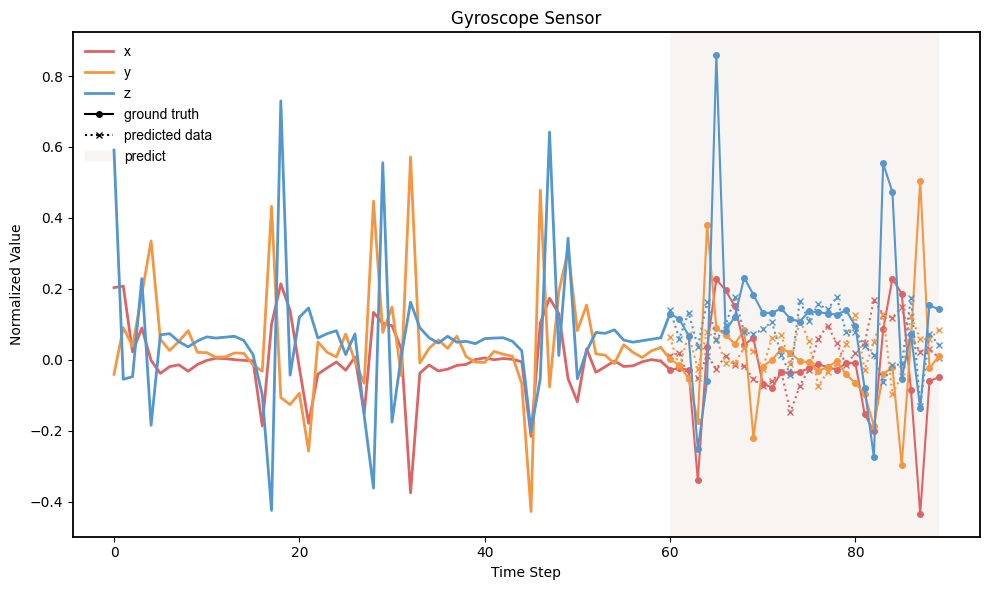

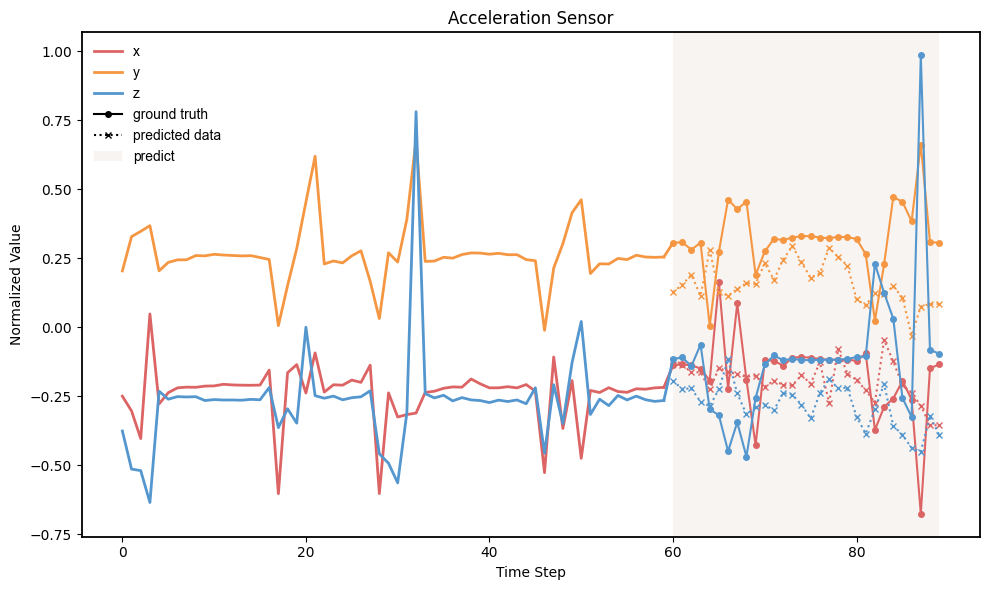

In [81]:
# -------------------------------
# RANDOMLY VISUALIZE MULTIPLE SAMPLES WITH GROUPED PLOTS (WITH CONNECTING LINE)
# -------------------------------
num_grouped_samples = 5
total_samples = len(train_dataset)
grouped_random_indices = random.sample(range(total_samples), num_grouped_samples)

for idx in grouped_random_indices:
    print(f"Grouped visualization for sample index: {idx}")
    sample = train_dataset[idx]
    visualize_new_grouped_sensors(sample, model, config, device)
